# ENMAP Query and Download

Below is an example for NZ.

I cannot seem to query the stc catalog for cloud, so i post filter.


In [32]:
from pystac_client import Client
import json

# This is the URL for the EOC Geoservice STAC catalogue
catalog = Client.open("https://geoservice.dlr.de/eoc/ogc/stac/v1/")

# Collections to be searched
collections = ["ENMAP_HSI_L2A"]

# Set bounding box [west, south, east, north]
# NZ
bbox = [166, -48, 179, -33]

# Set the cloud threshold
cloud_cover_max = 10

# Perform the search
search = catalog.search(
    collections=collections,
    bbox=bbox
)

matched = search.matched()
print(f"{matched} files found")

# Retrieve items using the generator for efficient paging
items = search.items()

# Initialize the FeatureCollection structure
feature_collection = {
    "type": "FeatureCollection",
    "features": []
}

download_links = []

for item in items:
    item_id = item.id
    cloud_cover = float(item.properties.get("eo:cloud_cover", 100))  # Default to 100 if not available
    item_datetime = item.properties.get("datetime", "")
    geometry = item.geometry
    biome_type = item.properties.get("enmap:biomeType", 'not available')
    
    # Retrieve asset URLs with safety checks
    image = item.assets.get("image", {}).href if "image" in item.assets else None
    thumbnail = item.assets.get("thumbnail", {}).href if "thumbnail" in item.assets else None

    if cloud_cover < cloud_cover_max and biome_type != 'not available':
        # Construct a GeoJSON Feature
        feature = {
            "type": "Feature",
            "geometry": geometry,
            "properties": {
                "id": item_id,
                "cloud": cloud_cover,
                "datetime": item_datetime,
                "biome": biome_type,
                "image": image,
                "thumbnail": thumbnail
            }
        }
        feature_collection["features"].append(feature)
        if image:
            download_links.append(image)

# Define the output GeoJSON file path
output_geojson = "enmap_query.geojson"

# Write the FeatureCollection to a GeoJSON file with indentation for readability
with open(output_geojson, 'w') as f:
    json.dump(feature_collection, f, indent=2)

# Save the download links to a text file
with open("enmap_download_links.txt", 'w') as f:
    for link in download_links:
        f.write(link + '\n')

print(f"GeoJSON FeatureCollection written to {output_geojson}")
print(f"Download links written to enmap_download_links.txt")

1215 files found
GeoJSON FeatureCollection written to enmap_query.geojson
Download links written to enmap_download_links.txt


# Intersect EMIT and ENMAP data
This takes a couple of hours to find all the overlapping images.


It initially queries the EMIT STAC, then for each EMIT image it queries the ENMAP STAC to find overlapping images.


It finds 3247 EMIT items with cloud less than 3% and 818 pairs within 3 days of an ENMAP image.

In [ ]:
from pystac_client import Client
from datetime import datetime, timedelta
import joblib

def emit_stac(bbox, datetime_bounds=None):
    """
    Query the STAC catalog with the specified bounding box and return matching items.

    :param bbox: Tuple of (swLon, swLat, neLon, neLat) defining the bounding box.
    :return: List of items returned by the query.
    """
    # Define the catalog
    # LPCLOUD catalog URL
    catalog_url = 'https://cmr.earthdata.nasa.gov/cloudstac/LPCLOUD/'
    catalog = Client.open(catalog_url)

    # Define search parameters with the passed bounding box
    search_params = {
        "collections": ["EMITL2ARFL_001"],  # Specify the collection
        "bbox": bbox,                       # Use the provided bounding box
        "query": {
            "eo:cloud_cover": {"lt": 3}   # Query parameter: cloud cover less than 2%
        }
    }

    # Run the STAC query
    query = catalog.search(**search_params)

    # List items returned by the query
    items = list(query.items())
    return items



def enmap_stac(bbox, datetime_bounds=None):
    """
    Query the STAC catalog with the specified bounding box and return matching items.

    :param bbox: List of [swLon, swLat, neLon, neLat] defining the bounding box.
    :return: ItemCollection returned by the query.
    """
    # Open the catalog
    catalog_url = "https://geoservice.dlr.de/eoc/ogc/stac/v1/"
    catalog = Client.open(catalog_url)

    # Collections to be searched
    collections = ["ENMAP_HSI_L2A"]

    # Perform the search
    search = catalog.search(
        collections=collections,
        bbox=bbox,
        datetime=datetime_bounds
    )

    # Return the items collection
    items = search.item_collection()
    return items

# Australia BBOX
bounding_box = [112,-44, 154,-9]

emit_items = emit_stac(bounding_box)

print(f"Found {len(emit_items)} EMIT items.")
datetime_buffer_days = 3
matched_items = []

for item in emit_items:
    print('.', end='')
    item_bbox = item.bbox
    # Build a STAC query for the ENMAP catalog
    start_datetime = item.datetime - timedelta(days=datetime_buffer_days)
    end_datetime = item.datetime + timedelta(days=datetime_buffer_days)
    stack_datetime = f"{start_datetime.strftime('%Y-%m-%dT%H:%M:%S')}Z/{end_datetime.strftime('%Y-%m-%dT%H:%M:%S')}Z"
    enmap_items = enmap_stac(item_bbox, datetime_bounds=stack_datetime)
    if len(enmap_items) > 0:
        for enmap_item in enmap_items:
            cloud_cover = float(enmap_item.properties["eo:cloud_cover"])
            if cloud_cover < 3: # Can't seem to query their stack for cloud cover
                # Add the two items to the matched_items
                matched_items.append((item, enmap_item))           
                print(f"\nEnmap ID: {enmap_item.id}, EMIT ID: {item.id}, Date: {item.datetime}")
    
# Save the matched items to a pickle file
joblib.dump(matched_items, 'matched_items.pkl')






### Graph of the matched pairs

818


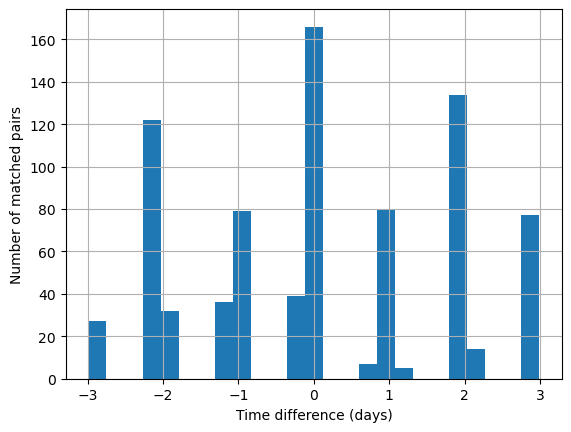

In [ ]:
from datetime import datetime
import matplotlib.pyplot as plt
import joblib


# Load the matched items from the pickle file
matched_items = joblib.load('matched_items.pkl')


def parse_datetime(datetime_str):
    # Try to parse datetime with and without microseconds
    try:
        return datetime.strptime(datetime_str, "%Y-%m-%dT%H:%M:%S.%fZ")
    except ValueError:
        return datetime.strptime(datetime_str, "%Y-%m-%dT%H:%M:%SZ")

# Make a list of the time difference between the two acquisitions
time_differences = []

for item in matched_items:
    try:
        enmap_time_str = item[1].properties["datetime"]
        emit_time_str = item[0].properties["datetime"]

        enmap_datetime = parse_datetime(enmap_time_str)
        emit_datetime = parse_datetime(emit_time_str)

        time_difference = enmap_datetime - emit_datetime
        time_differences.append(time_difference.total_seconds() / 60 / 60 / 24)  # Convert to hours
    except ValueError as e:
        print(f"Failed to parse datetime format for enmap: {enmap_time_str} or emit: {emit_time_str}")
        continue

# Plot a histogram of the time differences


plt.hist(time_differences, bins=25)
plt.xlabel("Time difference (days)")
plt.ylabel("Number of matched pairs")
plt.grid()


## Find the unique ids of the cloud free same day matches

Find the unique ids of the cloud free same day matches

In [11]:
from datetime import datetime
import json
from shapely.geometry import shape
import os

# Specify a directory to save the downloaded files
SAVE_DIRECTORY = "/mnt/e/Temp/aus_matched"


def parse_datetime(datetime_str):
    # Try to parse datetime with and without microseconds
    try:
        return datetime.strptime(datetime_str, "%Y-%m-%dT%H:%M:%S.%fZ")
    except ValueError:
        return datetime.strptime(datetime_str, "%Y-%m-%dT%H:%M:%SZ")

def get_emit_assets(item):
    item_assets = item.assets
    asset_keys = list(item_assets.keys())
    # Collect the href links for assets with '001/' in the keys
    emit_assets = [item_assets[key].href for key in asset_keys if '001/' in key]
    return emit_assets

def create_geojson_feature_collection(matched_items):
    features = []

    for item in matched_items:
        emit_id = item[0].id
        enmap_id = item[1].id
        emit_datetime = parse_datetime(item[0].properties["datetime"]).strftime("%Y-%m-%d %H:%M:%S")
        enmap_datetime = parse_datetime(item[1].properties["datetime"]).strftime("%Y-%m-%d %H:%M:%S")
        emit_cloud_cover = float(item[0].properties["eo:cloud_cover"])
        enmap_cloud_cover = float(item[1].properties["eo:cloud_cover"])

        emit_geometry = item[0].geometry
        enmap_geometry = item[1].geometry
        
        emit_feature = {
            "type": "Feature",
            "geometry": emit_geometry,
            "properties": {
                "id": emit_id,
                "datetime": emit_datetime,
                "cloud_cover": emit_cloud_cover,
                "type": "emit"
            }
        }
        
        enmap_feature = {
            "type": "Feature",
            "geometry": enmap_geometry,
            "properties": {
                "id": enmap_id,
                "datetime": enmap_datetime,
                "cloud_cover": enmap_cloud_cover,
                "type": "enmap"
            }
        }

        features.append(emit_feature)
        features.append(enmap_feature)

    feature_collection = {
        "type": "FeatureCollection",
        "features": features
    }

    return feature_collection

# Main code execution
cloud_threshold = 10
days_threshold = 0.14
filtered_items = []  # List to store items meeting all criteria
enmap_urls = []
emit_urls = []

for item in matched_items:
    enmap_cloud_cover = float(item[1].properties["eo:cloud_cover"])
    emit_cloud_cover = float(item[0].properties["eo:cloud_cover"])
    
    if enmap_cloud_cover > cloud_threshold or emit_cloud_cover > cloud_threshold:
        continue
    
    enmap_datetime = parse_datetime(item[1].properties["datetime"])
    emit_datetime = parse_datetime(item[0].properties["datetime"])
    time_difference = abs((enmap_datetime - emit_datetime).total_seconds() / 60 / 60 / 24)  # Convert to days
    
    if time_difference > days_threshold:
        continue

    enmap_polygon = shape(item[1].geometry)
    emit_polygon = shape(item[0].geometry)
    if not enmap_polygon.intersects(emit_polygon):
        continue

    
    filtered_items.append(item)
    enmap_urls.append(item[1].assets["image"].href)
    emit_urls.extend(get_emit_assets(item[0]))

geojson_feature_collection = create_geojson_feature_collection(filtered_items)

# Get the unique URLs
emit_urls = list(set(emit_urls))
enmap_urls = list(set(enmap_urls))

# Print results
print(f"Found {len(enmap_urls)} unique Enmap IDs and {len(emit_urls)} unique EMIT IDs.")
print(f"Created GeoJSON FeatureCollection with {len(geojson_feature_collection['features'])} features.")

with open(os.path.join(SAVE_DIRECTORY,'matched_features.geojson'), 'w') as f:
    json.dump(geojson_feature_collection, f, indent=2)

# Save the unique URLs to a text file
with open(os.path.join(SAVE_DIRECTORY,'enmap_urls.txt'), 'w') as f:
    for url in enmap_urls:
        f.write(f"{url}\n")

with open(os.path.join(SAVE_DIRECTORY,'emit_urls.txt'), 'w') as f:
    for url in emit_urls:
        f.write(f"{url}\n")
    


Found 91 unique Enmap IDs and 129 unique EMIT IDs.
Created GeoJSON FeatureCollection with 264 features.


### ENMAP Downloader

In [ ]:
#!/usr/bin/env python3

import os
import requests
import logging
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
from tqdm import tqdm
from bs4 import BeautifulSoup
from urllib.parse import urlparse, parse_qs, urlencode, urlunparse
import getpass

# ============================
# Logging Configuration
# ============================
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler("download_enmap.log"),
        logging.StreamHandler()
    ]
)

class SessionWithRetry(requests.Session):
    """
    Custom session class with retry strategy.
    """
    def __init__(self, retries=3, backoff_factor=1, status_forcelist=(429, 500, 502, 503, 504)):
        super().__init__()
        retry_strategy = Retry(
            total=retries,
            backoff_factor=backoff_factor,
            status_forcelist=status_forcelist,
            allowed_methods=["GET", "POST"]
        )
        adapter = HTTPAdapter(max_retries=retry_strategy)
        self.mount("https://", adapter)
        self.mount("http://", adapter)

def download_enmap(urls, username, password, download_folder=None):
    """
    Downloads multiple GeoTIFF files from an authenticated service using a single authentication session.

    Parameters:
    - urls (str or list of str): A single URL or a list of direct URLs to the GeoTIFF files.
    - download_folder (str): The local directory to save the downloaded files.
    - username (str): Your authentication username.
    - password (str): Your authentication password.

    Raises:
    - Exception: If any step in the authentication or download process fails.
    """
    # Convert single URL string to a list for uniform processing
    if isinstance(urls, str):
        urls = [urls]
    elif not isinstance(urls, list):
        logging.error("The 'urls' parameter must be a list of URLs or a single URL string.")
        raise ValueError("The 'urls' parameter must be a list of URLs or a single URL string.")

    # Set the save directory to current directory if not specified
    if download_folder is None:
        download_folder = os.getcwd()
    else:
        # Create the directory if it does not exist
        os.makedirs(download_folder, exist_ok=True)
    logging.info(f"Download folder set to: {download_folder}")

    # Initialize a session with retry strategy
    session = SessionWithRetry()

    # Define common headers to mimic a browser
    headers = {
        "User-Agent": (
            "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
            "AppleWebKit/537.36 (KHTML, like Gecko) "
            "Chrome/133.0.0.0 Safari/537.36"
        ),
        "Accept": (
            "text/html,application/xhtml+xml,application/xml;q=0.9,"
            "image/avif,image/webp,image/apng,*/*;q=0.8,"
            "application/signed-exchange;v=b3;q=0.7"
        ),
        "Accept-Language": "en-AU,en;q=0.9",
    }

    try:
        # Step 1: Authenticate and obtain the ticket
        first_url = urls[0]
        login_service_url = first_url
        login_url = f"https://sso.eoc.dlr.de/eoc/auth/login?service={login_service_url}"
        headers["Referer"] = login_url

        logging.info(f"Initiating authentication with login URL: {login_url}")

        # GET the login page to retrieve hidden form fields
        response = session.get(login_url, headers=headers)
        response.raise_for_status()
        logging.info("Successfully retrieved the login page.")

        # Parse the login page HTML
        soup = BeautifulSoup(response.text, 'html.parser')

        # Find the login form
        login_form = soup.find('form')
        if not login_form:
            logging.error("Login form not found on the login page.")
            raise Exception("Login form not found on the login page.")

        # Extract all form inputs
        form_data = {}
        for input_tag in login_form.find_all('input'):
            input_name = input_tag.get('name')
            input_value = input_tag.get('value', '')
            if input_name:
                form_data[input_name] = input_value

        # Update form data with username and password
        form_data.update({
            'username': username,
            'password': password,
            '_eventId': 'submit',         # Typically required for form submission
            'geolocation': '',            # Assuming geolocation is optional/empty
        })

        logging.info("Submitting login credentials.")
        # POST the login form with credentials
        post_response = session.post(login_url, data=form_data, headers=headers, allow_redirects=False)
        post_response.raise_for_status()

        # Check for redirection to get the ticket
        if post_response.status_code != 302:
            logging.error("Login failed or unexpected response received.")
            raise Exception("Login failed or unexpected response received.")

        # Extract the 'Location' header to get the redirected URL with the ticket
        redirect_url = post_response.headers.get('Location')
        if not redirect_url:
            logging.error("Redirection URL not found after login.")
            raise Exception("Redirection URL not found after login.")

        # Parse the redirected URL to extract the ticket parameter
        parsed_redirect = urlparse(redirect_url)
        query_params = parse_qs(parsed_redirect.query)
        ticket = query_params.get('ticket', [None])[0]
        if not ticket:
            logging.error("Authentication ticket not found in the redirected URL.")
            raise Exception("Authentication ticket not found in the redirected URL.")

        logging.info(f"Authentication successful. Ticket obtained: {ticket}")

        # Iterate through the list of URLs and download each file
        for idx, url in enumerate(urls, start=1):
            logging.info(f"Processing URL ({idx}/{len(urls)}): {url}")

            # Parse the download URL to check if ticket is already present
            parsed_url = urlparse(url)
            download_query = parse_qs(parsed_url.query)

            # If 'ticket' is not present, append it
            if 'ticket' not in download_query:
                download_query['ticket'] = ticket
                new_query = urlencode(download_query, doseq=True)
                download_url_with_ticket = urlunparse(parsed_url._replace(query=new_query))
                logging.debug(f"Appended ticket to URL: {download_url_with_ticket}")
            else:
                download_url_with_ticket = url

            # Update headers for the download request
            download_headers = headers.copy()
            download_headers["Referer"] = "https://sso.eoc.dlr.de/"

            try:
                # Send the GET request to download the file
                with session.get(download_url_with_ticket, headers=download_headers, stream=True, timeout=(15, 60)) as download_response:
                    download_response.raise_for_status()
                    logging.info(f"Started downloading: {url}")

                    # Extract the filename from the URL
                    filename = os.path.basename(parsed_url.path)
                    if not filename:
                        filename = f"downloaded_file_{idx}.tif"  # Fallback filename

                    file_path = os.path.join(download_folder, filename)

                    # Get the total file size for the progress bar
                    total_size_in_bytes = int(download_response.headers.get('content-length', 0))
                    block_size = 1024 * 1024  # 1MB

                    # Initialize the progress bar
                    progress_bar = tqdm(
                        total=total_size_in_bytes, 
                        unit='iB', 
                        unit_scale=True, 
                        desc=filename,
                        leave=True
                    )

                    # Write the content to a file in chunks
                    with open(file_path, 'wb') as file:
                        for chunk in download_response.iter_content(chunk_size=block_size):
                            if chunk:
                                file.write(chunk)
                                progress_bar.update(len(chunk))
                    progress_bar.close()

                    # Verify if the download completed successfully
                    if total_size_in_bytes != 0 and progress_bar.n != total_size_in_bytes:
                        logging.warning(f"Mismatch in expected size for '{filename}'. Download may be incomplete.")
                    else:
                        logging.info(f"Successfully downloaded '{filename}' to '{download_folder}'.")

            except requests.exceptions.HTTPError as download_http_err:
                logging.error(f"HTTP error occurred while downloading '{url}': {download_http_err}")
            except requests.exceptions.RequestException as download_req_err:
                logging.error(f"Request exception occurred while downloading '{url}': {download_req_err}")
            except Exception as download_err:
                logging.error(f"An unexpected error occurred while downloading '{url}': {download_err}")

    except requests.exceptions.RequestException as auth_err:
        logging.error(f"An error occurred during the authentication request: {auth_err}")
        raise Exception(f"An error occurred during the authentication request: {auth_err}")
    except Exception as ex:
        logging.error(f"An error occurred: {ex}")
        raise Exception(f"An error occurred: {ex}")

   
if __name__ == "__main__":
    import sys

    # Usage is python download_emit.py url_file save_dir username password
    if len(sys.argv) < 2:
        print("Usage: python download_enmap.py url_file")
        sys.exit(1)
    
    # Read the URLs from the file
    url_file = sys.argv[1]
    with open(url_file, 'r') as f:
        urls = f.readlines()
    urls = [url.strip() for url in urls]

    # Save directory is the same as the url file
    save_dir = os.path.dirname(url_file)
    if not save_dir:
        save_dir = os.getcwd()

    # EnMap credentials
    username = getpass.getpass("Enter your EnMap username: ")
    password = getpass.getpass("Enter your EnMap password: ")

    # Call the download function
    download_enmap(urls, username, password, save_dir)

### EMIT Downloader

In [ ]:
#!/usr/bin/env python3

import os
import requests
import logging
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry
from tqdm import tqdm
import getpass

# ============================
# Logging Configuration
# ============================
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler("download_emit.log"),
        logging.StreamHandler()
    ]
)

class SessionWithHeaderRedirection(requests.Session):
    """
    Custom session class to handle authentication and maintain headers during redirects.
    """
    AUTH_HOST = 'urs.earthdata.nasa.gov'

    def __init__(self, username, password):
        super().__init__()
        self.auth = (username, password)

    def rebuild_auth(self, prepared_request, response):
        """
        Overrides the default rebuild_auth to maintain headers when redirected to or from the authentication host.
        """
        headers = prepared_request.headers
        url = prepared_request.url

        if 'Authorization' in headers:
            original_parsed = requests.utils.urlparse(response.request.url)
            redirect_parsed = requests.utils.urlparse(url)

            if (original_parsed.hostname != redirect_parsed.hostname) and \
               (redirect_parsed.hostname != self.AUTH_HOST) and \
               (original_parsed.hostname != self.AUTH_HOST):
                del headers['Authorization']

        return

def setup_session(username, password):
    """
    Sets up the session with retry strategy.

    Parameters:
        username (str): Earthdata Login username.
        password (str): Earthdata Login password.

    Returns:
        requests.Session: Configured session object.
    """
    session = SessionWithHeaderRedirection(username, password)
    retry_strategy = Retry(
        total=3,  # Total number of retries
        status_forcelist=[429, 500, 502, 503, 504],  # HTTP status codes to retry
        allowed_methods=["GET", "POST"],  # HTTP methods to retry
        backoff_factor=1  # A backoff factor for sleep between retries
    )
    adapter = HTTPAdapter(max_retries=retry_strategy)
    session.mount("https://", adapter)
    session.mount("http://", adapter)
    return session

def download_emit(urls, username, password, save_dir=None):
    """
    Downloads one or multiple files from given URLs using Earthdata Login credentials.

    Parameters:
        urls (str or list of str): URL(s) of the files to download.
        username (str): Your Earthdata Login username.
        password (str): Your Earthdata Login password.
        save_dir (str, optional): Directory to save the downloaded files. Defaults to current directory.

    Raises:
        requests.exceptions.HTTPError: If an HTTP error occurs during any download.
        Exception: For any other exceptions that may occur.
    """
    # Convert single URL string to a list for uniform processing
    if isinstance(urls, str):
        urls = [urls]
    elif not isinstance(urls, list):
        raise ValueError("The 'urls' parameter must be a list of URLs or a single URL string.")

    # Set the save directory to current directory if not specified
    if save_dir is None:
        save_dir = os.getcwd()
    else:
        # Create the directory if it does not exist
        os.makedirs(save_dir, exist_ok=True)

    # Initialize the custom session with credentials and retry strategy
    session = setup_session(username, password)

    # Iterate through each URL and download the file
    for idx, url in enumerate(urls, start=1):
        # Extract the filename from the URL
        filename = os.path.basename(url)
        if not filename:
            filename = f"downloaded_file_{idx}.tif"  # Fallback filename if extraction fails
        save_path = os.path.join(save_dir, filename)

        try:
            # Submit the request using the session
            with session.get(url, stream=True) as response:
                logging.info(f"\nRequesting URL ({idx}/{len(urls)}): {url}")
                logging.info(f"HTTP Status Code: {response.status_code}")

                # Raise an exception in case of HTTP errors
                response.raise_for_status()

                # Get the total file size for the progress bar
                total_size_in_bytes = int(response.headers.get('content-length', 0))
                block_size = 1024 * 1024  # 1MB

                # Initialize the progress bar
                progress_bar = tqdm(total=total_size_in_bytes, unit='iB', unit_scale=True, desc=filename)

                # Save the file in chunks with progress update
                with open(save_path, 'wb') as fd:
                    for chunk in response.iter_content(chunk_size=block_size):
                        if chunk:  # Filter out keep-alive chunks
                            fd.write(chunk)
                            progress_bar.update(len(chunk))
                progress_bar.close()

                # Verify if the download completed successfully
                if total_size_in_bytes != 0 and progress_bar.n != total_size_in_bytes:
                    logging.warning(f"Mismatch in expected size for '{filename}'. Download may be incomplete.")
                else:
                    logging.info(f"Successfully downloaded '{filename}' to '{save_dir}'.")

        except requests.exceptions.HTTPError as http_err:
            logging.error(f"HTTP error occurred while downloading '{filename}': {http_err}")
        except requests.exceptions.RequestException as req_err:
            logging.error(f"Request exception occurred while downloading '{filename}': {req_err}")
        except Exception as err:
            logging.error(f"An unexpected error occurred while downloading '{filename}': {err}")


if __name__ == "__main__":
    import sys

    # Usage is python download_emit.py url_file
    if len(sys.argv) < 2:
        print("Usage: python download_emit.py url_file")
        sys.exit(1)
    
    # Read the URLs from the file
    url_file = sys.argv[1]
    with open(url_file, 'r') as f:
        urls = f.readlines()
    urls = [url.strip() for url in urls]

    # Save directory is the same as the url file
    save_dir = os.path.dirname(url_file)
    if not save_dir:
        save_dir = os.getcwd()

    # Earthdata credentials
    username = getpass.getpass("Enter your EarthData username: ")
    password = getpass.getpass("Enter your EarthData password: ")

    # Call the download function
    download_emit(urls, username, password, save_dir)



